# Turkish Delight Airlines Aircraft Analysis

## Business Understanding

"Turkish Delight Airlines," is expanding into the aviation industry with the goal of operating both commercial and private aircraft, primarily focusing on routes between Turkey and the USA. The company’s leadership is unfamiliar with the risks associated with aircraft operations and is seeking data-driven insights to make informed decisions on which aircraft models to purchase for safe and efficient operations.

## Data Understanding

In [1]:
# Import the required libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport, profile_report
from project_functions.functions import transform_location
from project_functions.functions import replace_missing_values
from plotnine import *
import pytimetk as tk
from plydata.cat_tools import *


In [2]:
# Read the data
aviation_data = pd.read_csv("data/AviationData.csv", encoding='latin1')

In [31]:
# Create a Profile Report
profile = ProfileReport(df=aviation_data)
profile.to_file("profile_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 157.81it/s]


In [3]:
# Drop the columns 
columns_to_drop = [
    'Latitude','Longitude',
    'Airport.Code','Airport.Name',
    'FAR.Description',
    'Schedule', 
    'Air.carrier', 
    'Publication.Date',
    'Accident.Number',
    'Registration.Number',
    'Aircraft.damage'
 ]

aviation_data.drop(columns_to_drop,inplace=True,axis=1)

In [4]:
# Update columns names
aviation_data.rename(columns = lambda x : x.replace("."," ").title(),inplace=True)

In [5]:
# Injury Severity and Total Fatal Injuries have same information. Combine them into one
extracted_numbers = aviation_data['Injury Severity'].str.extract(r'\((\d+)\)').astype(float)
aviation_data['Total Fatal Injuries'] = aviation_data['Total Fatal Injuries'].fillna(extracted_numbers[0])
aviation_data['Total Fatal Injuries'] = aviation_data['Total Fatal Injuries'].fillna(0).astype(int)
aviation_data.drop(['Injury Severity'],inplace=True,axis=1)

In [6]:
# Fill missing values with 0 and convert it to type 'int'
columns_to_fill = ['Total Serious Injuries', 'Total Minor Injuries', 'Total Uninjured']
aviation_data[columns_to_fill] = aviation_data[columns_to_fill].fillna(0).astype(int)

In [7]:
# Chnage the Event Date to datetime
aviation_data['Event Date'] = pd.to_datetime(aviation_data['Event Date'])

In [8]:
# Adjust the value of the Location column
aviation_data['Location'] = aviation_data.apply(transform_location, axis=1)


In [9]:
# Re-format the Country and Location columns
aviation_data['Country'] = aviation_data['Country'].apply(replace_missing_values)
aviation_data['Country'] = aviation_data['Country'].str.title()
aviation_data['Location'] = aviation_data['Location'].fillna('Unknown')
aviation_data['Location'] = aviation_data['Location'].replace('Un', 'Unknown')

In [10]:
state_codes = pd.read_csv("data/USState_Codes.csv")
state_codes_dict = dict(zip(state_codes['Abbreviation'], state_codes['US_State']))

aviation_data['Location'] = aviation_data['Location'].map(state_codes_dict )


In [11]:
aviation_data['Engine Type'] = aviation_data['Engine Type'].apply(replace_missing_values)
aviation_data['Aircraft Category'] = aviation_data.apply(
    lambda row: row['Engine Type'] if pd.isna(row['Aircraft Category']) and row['Engine Type'] in ['Turbo Fan', 'Geared Turbofan'] else row['Aircraft Category'],
    axis=1
)
aviation_data['Engine Type'].dropna(inplace=True)
aviation_data['Aircraft Category'] = aviation_data['Aircraft Category'].replace('Turbo Fan', 'Airplane')
aviation_data = aviation_data[aviation_data['Aircraft Category'] == 'Airplane']

In [12]:
aviation_data['Number Of Engines'] = aviation_data['Number Of Engines'].fillna(0).astype(int)
aviation_data = aviation_data[aviation_data['Number Of Engines'].isin([2, 3, 4])]

In [13]:
aviation_data['Make'] = aviation_data['Make'].str.title()

In [14]:
max_date = aviation_data['Event Date'].max()
aviation_data = aviation_data[aviation_data['Event Date'] > max_date - pd.DateOffset(years=20)]

In [15]:
aviation_data = aviation_data[
    aviation_data['Purpose Of Flight'].isin(['Executive/Corporate', 'Business','Personal']) |
    aviation_data['Purpose Of Flight'].str.startswith('Public')
]

In [16]:
aviation_data['Weather Condition'] = aviation_data['Weather Condition'].apply(replace_missing_values)

In [17]:
aviation_data['Broad Phase Of Flight'] = aviation_data['Broad Phase Of Flight'].apply(replace_missing_values)


In [18]:
aviation_data['Report Status'] = aviation_data['Report Status'].apply(replace_missing_values)
aviation_data = aviation_data[aviation_data['Report Status'] != 'Unknown']
aviation_data['Report Status'].to_csv('data/report_status.csv', index=False)

In [19]:
category_df = pd.read_csv('data/categorized_accident_reasons.csv')


In [20]:
aviation_data['temp_index'] = range(len(aviation_data))
category_df['temp_index'] = range(len(category_df))
merged_df = aviation_data.merge(category_df, on='temp_index', suffixes=('', '_category'))

merged_df['Report Status'] = merged_df.apply(
    lambda row: row['Report Status'] if row['Report Status'] == 'Probable Cause' else row['Reason of the Accident'],
    axis=1
)
aviation_data = merged_df.drop(columns=['Reason of the Accident', 'temp_index'])


In [21]:
aviation_data['Category'] = aviation_data.apply(
    lambda row: row['Report Status'] if row['Report Status'] == 'Probable Cause' else row['Category'],
    axis=1
)
aviation_data.drop(columns=['Report Status'], inplace=True)

In [22]:
# if Report Status is 'Probable Cause' then the Category is 'Probable Cause'
aviation_data.drop('Event Id', axis=1, inplace=True)

In [24]:
aviation_data.to_csv('data/aviation_data_cleaned.csv', index=False)

## Exploratory Data Analysis

#### figure out

In [218]:
aviation_data = pd.read_csv('data/aviation_data_cleaned.csv')

In [219]:
pivot_table = aviation_data.pivot_table(index='Make', columns='Category', aggfunc='size', fill_value=0).sort_values(by='Mechanical Failure', ascending=False)
pivot_table['Percentage of Mechanical Failures'] = pivot_table['Mechanical Failure'] / pivot_table.sum(axis=1) * 100
pivot_table = pivot_table.reset_index()
pivot_table['Make'] = pivot_table['Make'].apply(lambda x: x if x in ['Cessna', 'Piper', 'Beech', 'Aero Commander'] else 'Other')
pivot_table

Category,Make,Mechanical Failure,Other,Pilot Error,Probable Cause,Weather Conditions,Percentage of Mechanical Failures
0,Cessna,17,48,173,47,2,5.923345
1,Beech,17,25,151,33,2,7.456140
2,Piper,13,24,128,33,1,6.532663
3,Aero Commander,1,2,10,1,0,7.142857
4,Other,1,0,0,0,0,100.000000
...,...,...,...,...,...,...,...
90,Other,0,0,1,0,0,0.000000
91,Other,0,1,4,2,0,0.000000
92,Other,0,0,0,1,0,0.000000
93,Other,0,1,0,0,1,0.000000


In [220]:
# Data Preparation
pivot_table = pivot_table\
    .melt(
        id_vars='Make', 
        value_vars=['Mechanical Failure', 'Pilot Error', 'Weather Conditions','Probable Cause', 'Other'], 
        var_name='Category', 
        value_name='Count'
        )
    
pivot_table = pivot_table.sort_values(by='Count', ascending=False)
pivot_table




,Make,Category,Count
95,Cessna,Pilot Error,173
96,Beech,Pilot Error,151
97,Piper,Pilot Error,128
380,Cessna,Other,48
285,Cessna,Probable Cause,47
...,...,...,...
206,Other,Weather Conditions,0
205,Other,Weather Conditions,0
204,Other,Weather Conditions,0
203,Other,Weather Conditions,0


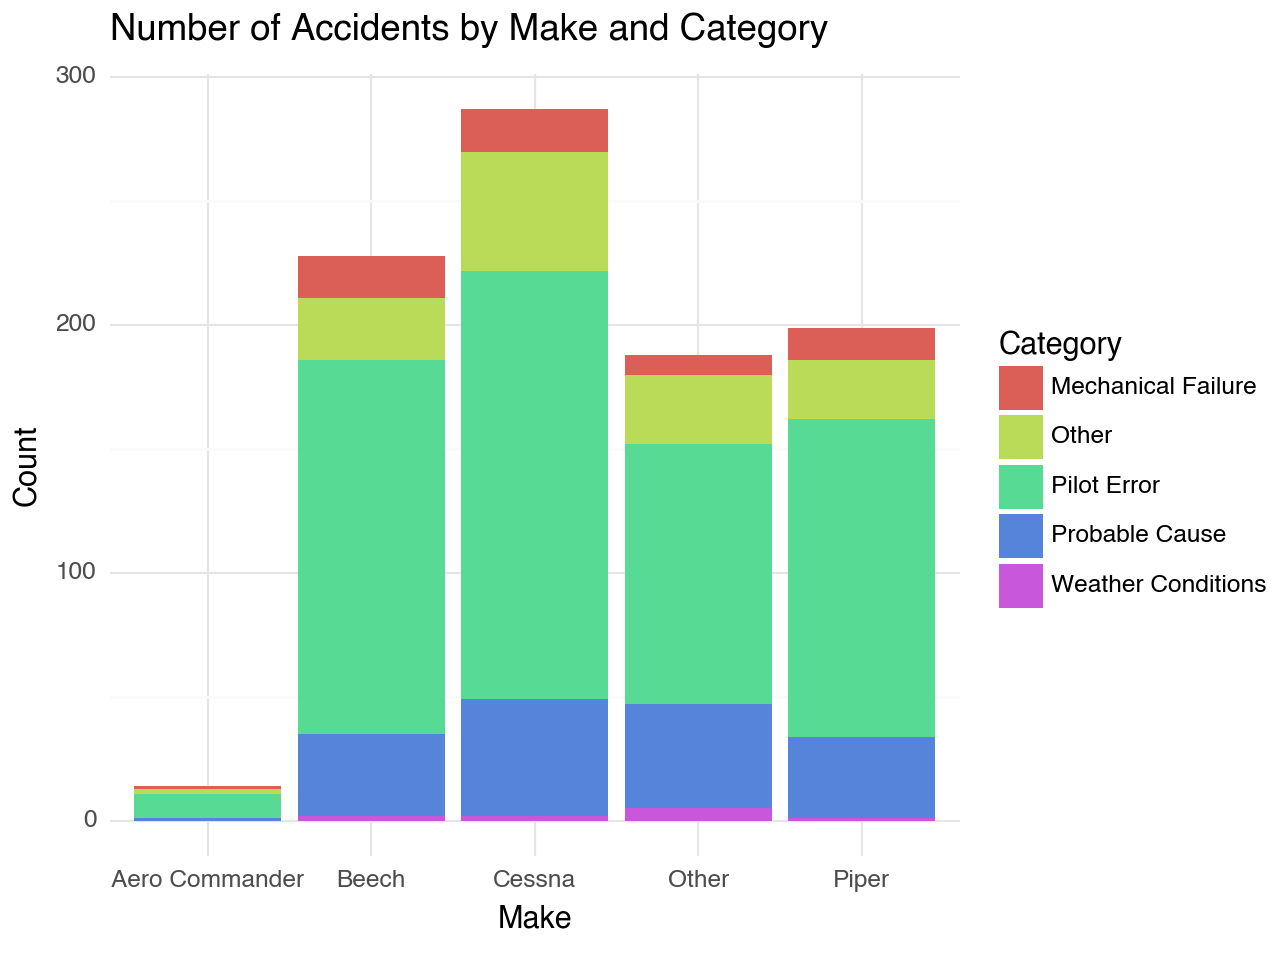

<Figure Size: (640 x 480)>

In [228]:
# Visualization
(
    ggplot(pivot_table, aes(x='Make', y='Count', fill='Category')) +
    geom_col() +
    labs(title='Number of Accidents by Make and Category', x='Make', y='Count') +
    theme_minimal()
)

#### Create scoring for Injury Categories

In [200]:
aviation_data_filtered_by_top_risky_make = aviation_data[~aviation_data['Make'].isin(['Cessna', 'Piper', 'Beech', 'Aero Commander'])]
aviation_data_filtered_by_top_risky_make['Weighted Score'] = aviation_data_filtered_by_top_risky_make['Total Fatal Injuries'] * 5\
+ aviation_data_filtered_by_top_risky_make['Total Serious Injuries'] * 3\
+ aviation_data_filtered_by_top_risky_make['Total Minor Injuries'] * 2

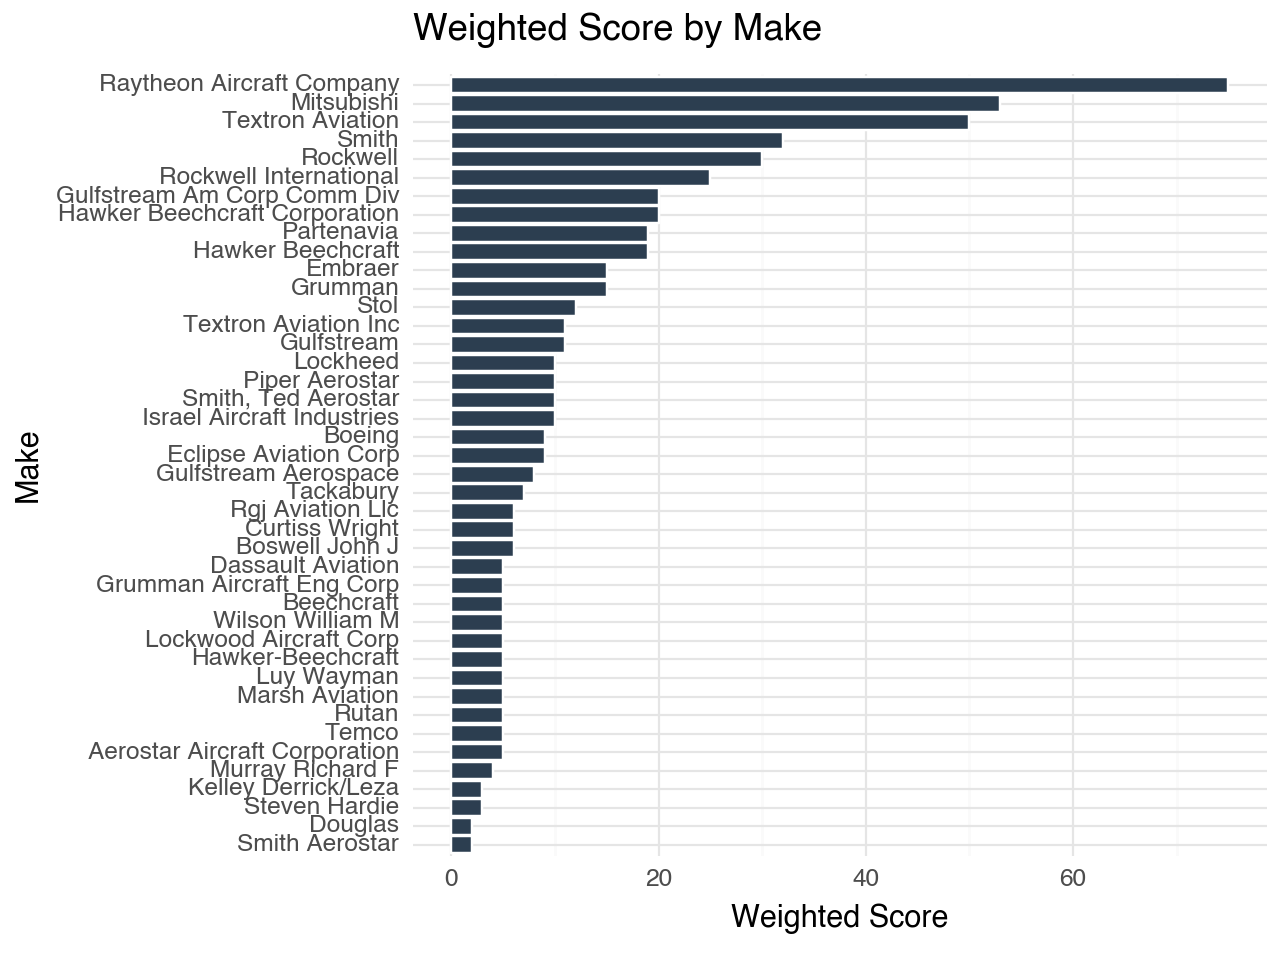

<Figure Size: (640 x 480)>

In [201]:
temp_df = aviation_data_filtered_by_top_risky_make.groupby('Make')['Weighted Score'].sum().sort_values(ascending=False).reset_index()
temp_df = temp_df[temp_df['Weighted Score'] != 0]\
            .sort_values(by='Weighted Score', ascending=False)\
            .assign(Make = lambda x : cat_reorder(x['Make'],x['Weighted Score']))
(
    ggplot(temp_df, aes(x='Make', y='Weighted Score')) +
    geom_col(fill='#2c3e50',color='white') +
    coord_flip() + 
    theme(axis_text_x=element_text(rotation=45, hjust=1)) +
    labs(title='Weighted Score by Make', x='Make', y='Weighted Score') +
    theme_minimal()
)

In [182]:
aviation_data_filtered_by_least_risky_injured_score = aviation_data_filtered_by_top_risky_make[~aviation_data_filtered_by_top_risky_make['Make'].isin(temp_df['Make'])]
aviation_data_filtered_by_least_risky_injured_score['Make'].value_counts()

Make
Learjet                           7
Canadair                          4
Piaggio                           4
Raytheon                          2
Eclipse Aviation Corporation      2
North American                    2
Bombardier                        2
Bombardier Inc                    2
Fouga                             2
Learjet Inc                       2
Dassault-Breguet                  2
Gates Lear Jet                    2
Mcdonnell Douglas                 2
Hawker Beechcraft Corp            2
American Legend                   1
Beagle                            1
American Champion Aircraft        1
Partenavia S.P.A.                 1
Hawker Siddeley                   1
Dieterich Robert A                1
Embraer S A                       1
Swearingen                        1
Jetson'S Aviation Llc             1
Lockwood                          1
Northrop                          1
Eclipse                           1
Embraer Executive Aircraft Inc    1
Pyka Inc               

In [217]:
date_df = aviation_data_filtered_by_least_risky_injured_score.groupby(['Make','Model']).max()['Event Date'].sort_values(ascending=False).reset_index()
# create a new column days since last accident
date_df['Days Since Last Accident'] = (max_date - date_df['Event Date']).dt.days
date_df.sort_values(by='Days Since Last Accident', ascending=False, inplace=True)
date_df.head(10)

,Make,Model,Event Date,Days Since Last Accident
63,Hawker Siddeley,DH-125,2002-12-16,7304
62,Learjet,45,2003-10-22,6994
61,Mcdonnell Douglas,DC-10-30,2004-04-10,6823
60,Lemuel May,Leza-Lockwood Aircam,2004-09-18,6662
59,Mcdonnell Douglas,MD-82,2004-09-26,6654
58,Dassault-Breguet,Falcon 20,2004-12-05,6584
57,Gulfstream American,690C,2005-02-10,6517
56,British Aerospace,BAE-125-700A,2005-03-08,6491
55,Raytheon,BE-390,2005-09-14,6301
54,Canadair,CL-600,2006-02-09,6153


In [193]:
aviation_data_filtered_by_least_risky_injured_score['Event Date'] = pd.to_datetime(aviation_data_filtered_by_least_risky_injured_score['Event Date'])

# Select the relevant columns and set 'Event Date' as the index
plot = aviation_data_filtered_by_least_risky_injured_score[['Event Date', 'Make']].set_index('Event Date')

# Group by 'Make' and resample by year, then count the number of rows
plot = plot.groupby('Make').resample('D').size()

# Display the result
plot = plot.reset_index(name='Total Accidents')
plot



,Make,Event Date,Total Accidents
0,American Champion Aircraft,2012-12-01,1
1,American Legend,2014-05-10,1
2,Beagle,2012-09-21,1
3,Beriev Aircraft Company,2009-10-30,1
4,Bombardier,2009-09-27,1
...,...,...,...
26977,Riley,2006-12-01,1
26978,Rogers,2010-04-29,1
26979,Ron Burleigh,2006-08-28,1
26980,Rupp,2006-05-05,1


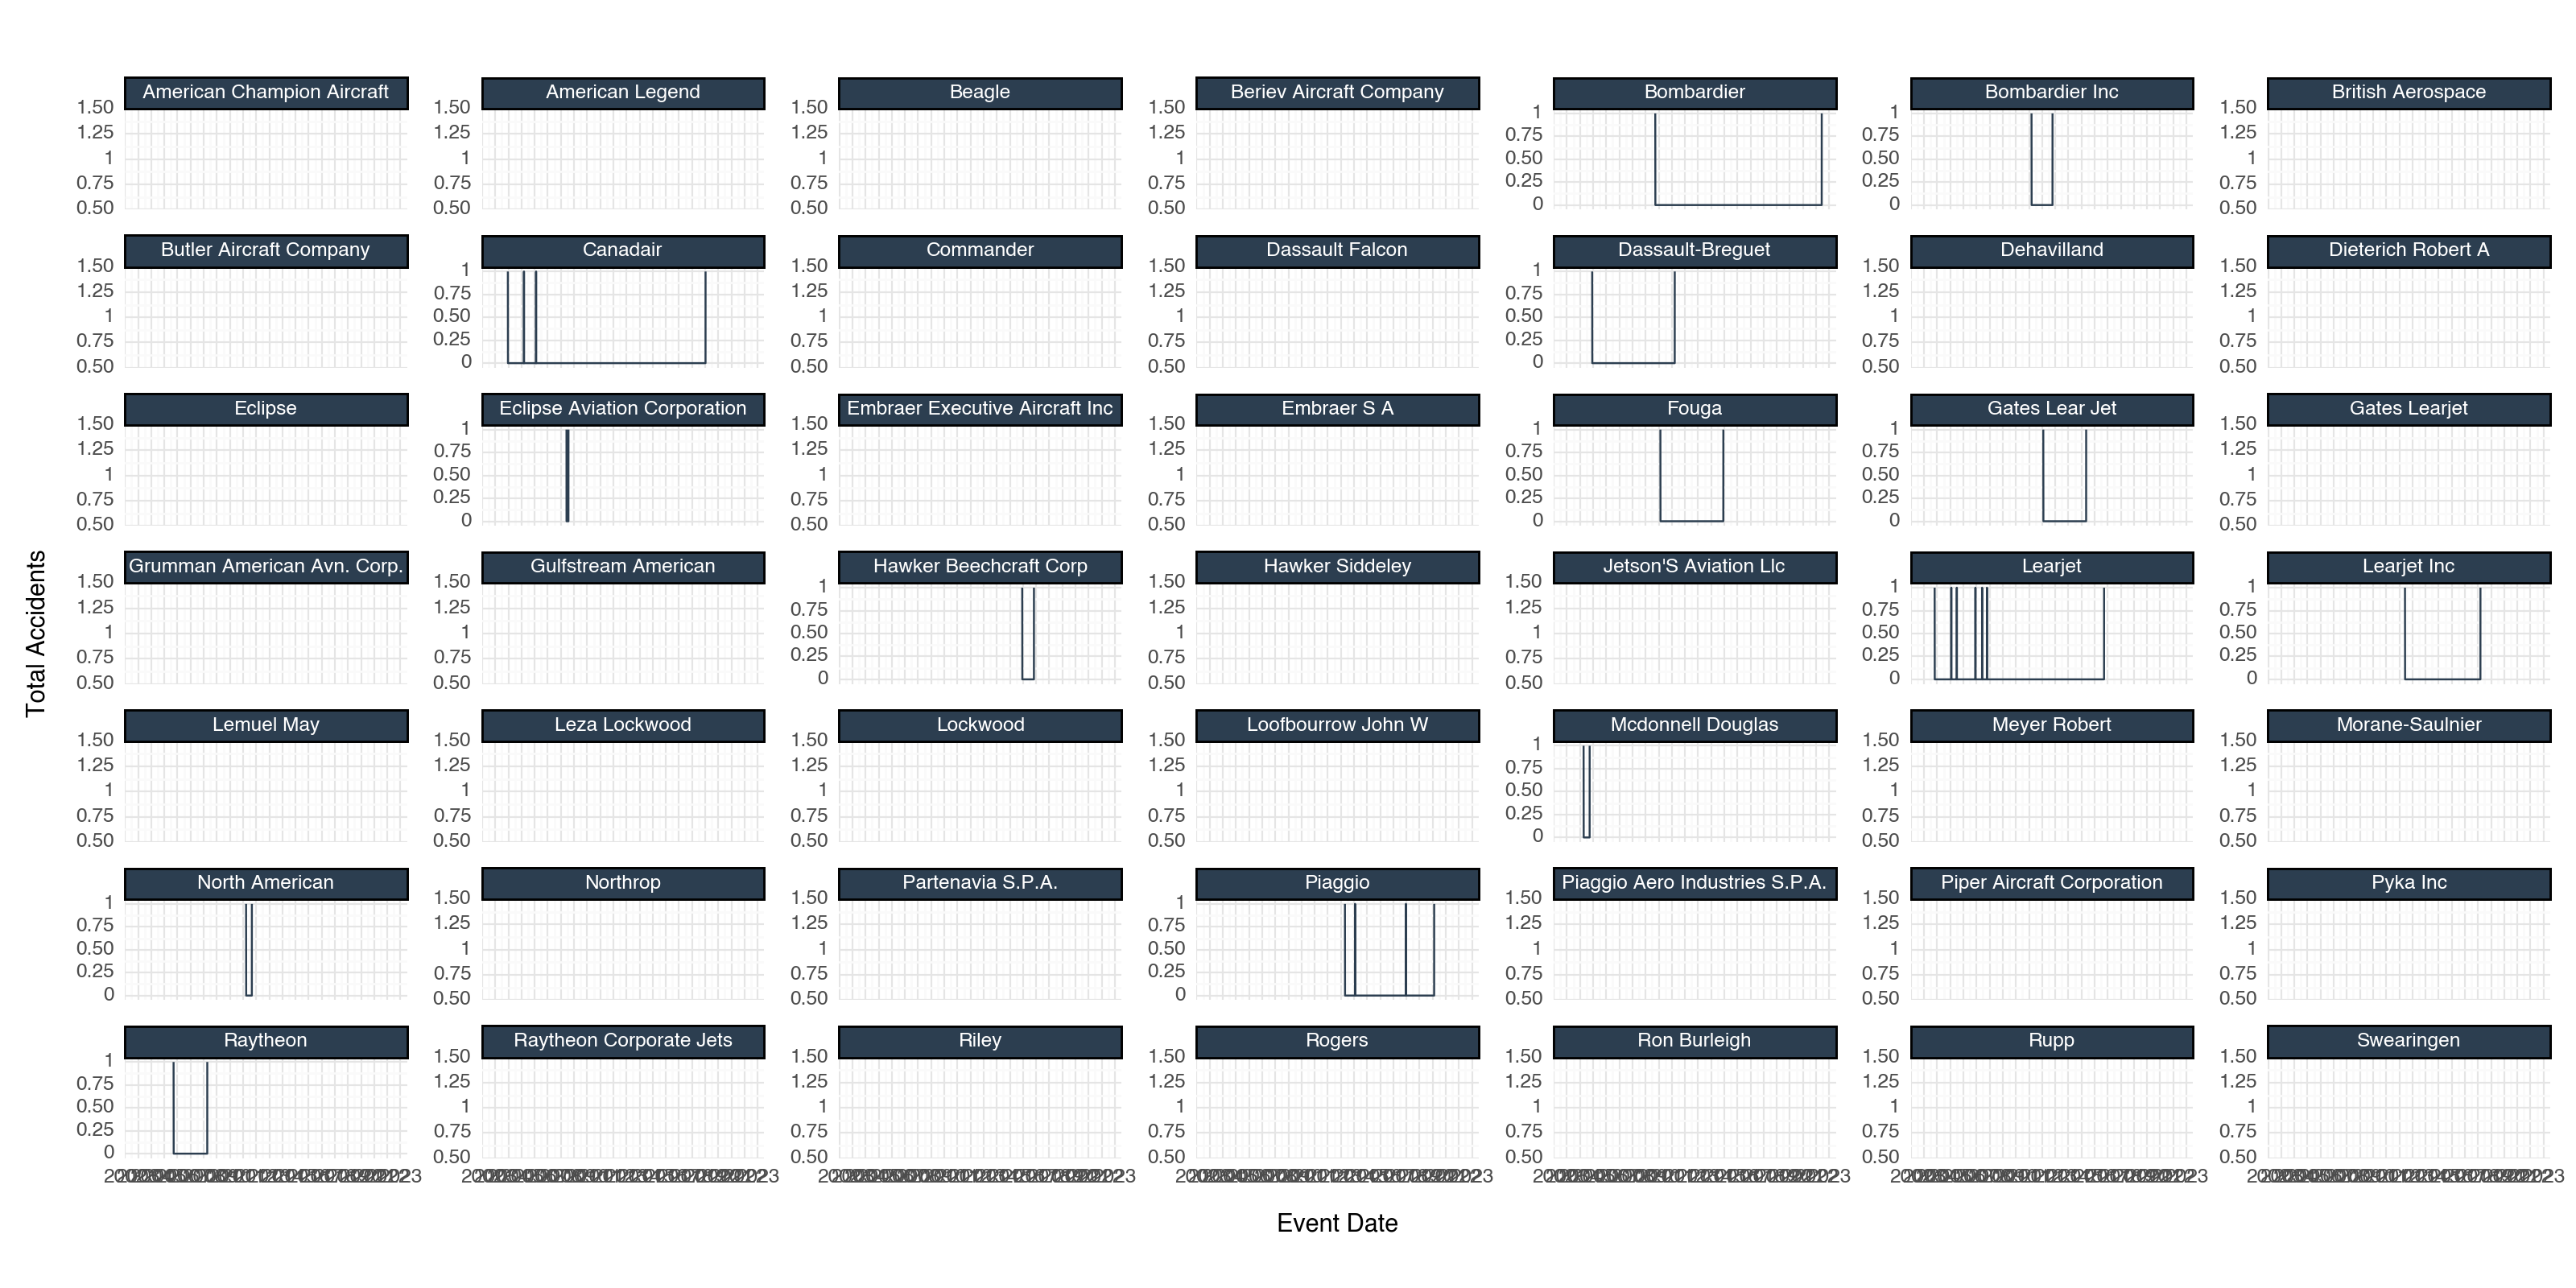

<Figure Size: (1600 x 800)>

In [202]:
ggplot(
    mapping = aes('Event Date','Total Accidents',color = 'Make'),
    data = plot
)\
+ geom_line(color = "#2C3E50")\
+ facet_wrap('Make',scales='free_y')\
+ scale_x_datetime(date_labels = '%Y',date_breaks='1 years')\
+ scale_color_cmap_d()\
+ theme_minimal()\
+ theme(
    strip_background = element_rect(fill = "#2c3e50"),
    strip_text       = element_text(color = "white"),
    legend_position = 'none',
    figure_size = (16,8),
    subplots_adjust = {'wspace' : 0.25},
    plot_title = element_text(ha='center')
)


In [154]:
# fatality rate by model
fatality_rate_by_make = aviation_data[['Make','Total Fatal Injuries']]\
    .groupby('Make')\
    .sum()\
    .sort_values('Total Fatal Injuries', ascending=False)\
    .reset_index()

fatality_rate_by_make = fatality_rate_by_make[fatality_rate_by_make['Total Fatal Injuries'] != 0]

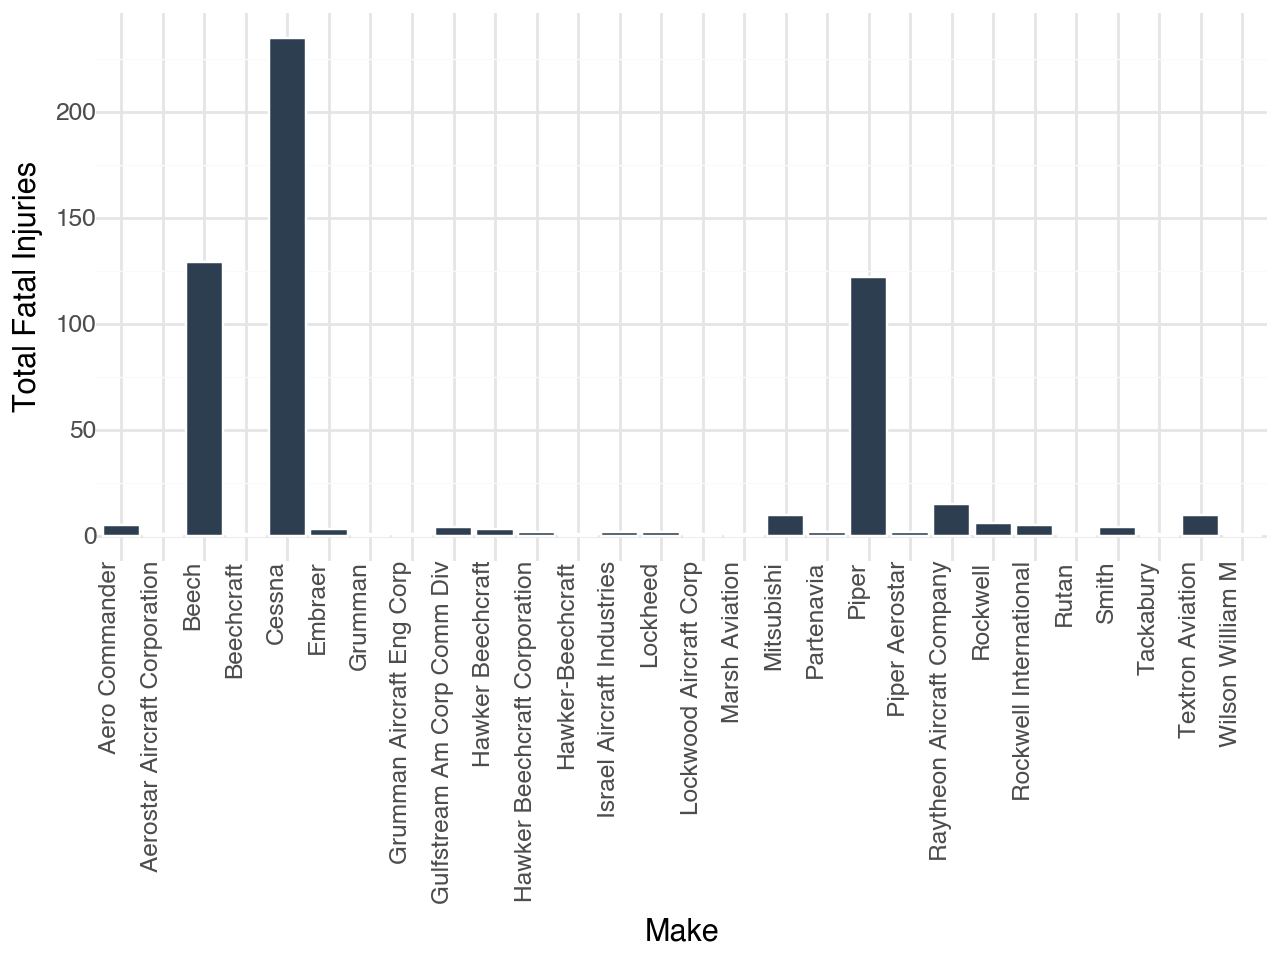

In [122]:

ggplot(
    mapping = aes('Make','Total Fatal Injuries'),
    data = fatality_rate_by_make
)\
+ geom_col(fill='#2c3e50',color='white')\
+ theme_minimal()\
+ theme(axis_text_x=element_text(angle=90, hjust=1))


In [129]:
temp_df = aviation_data[aviation_data['Make'] == 'Beech']
fatality_rate_by_beech_model = temp_df[['Model','Total Fatal Injuries']]\
    .groupby('Model')\
    .sum()\
    .sort_values('Total Fatal Injuries', ascending=False)\
    .reset_index()
fatality_rate_by_beech_model = fatality_rate_by_beech_model[fatality_rate_by_beech_model['Total Fatal Injuries'] != 0]


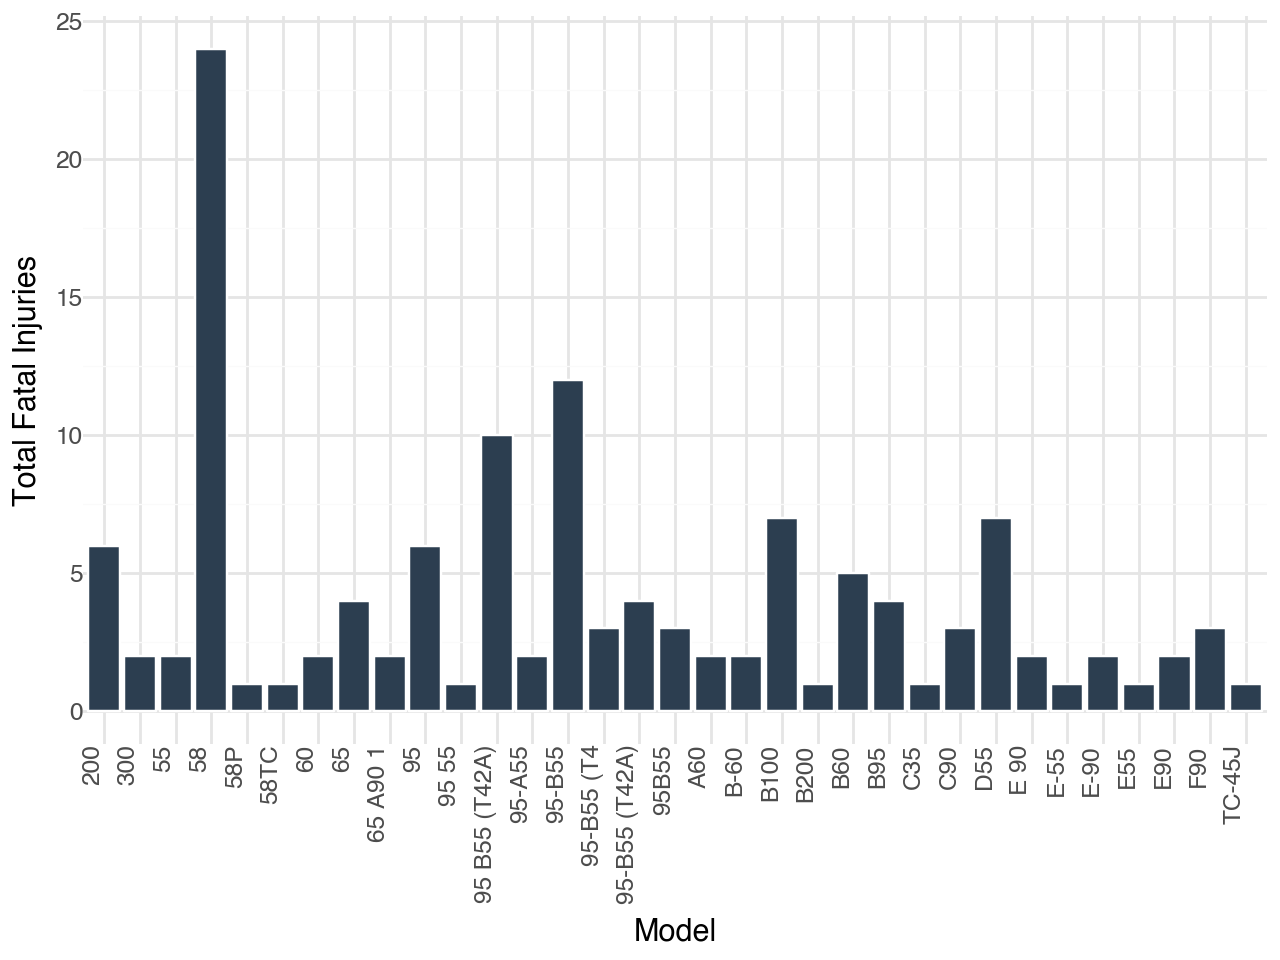

In [130]:
ggplot(
    mapping = aes('Model','Total Fatal Injuries'),
    data = fatality_rate_by_beech_model
)\
+ geom_col(fill='#2c3e50',color='white')\
+ theme_minimal()\
+ theme(axis_text_x=element_text(angle=90, hjust=1))

In [144]:
temp_df_time_series = temp_df\
    .summarize_by_time(
        date_column = 'Event Date',
        value_column = 'Total Fatal Injuries',
        freq = 'Y',
        agg_func = 'sum',
        wide_format = False
    )

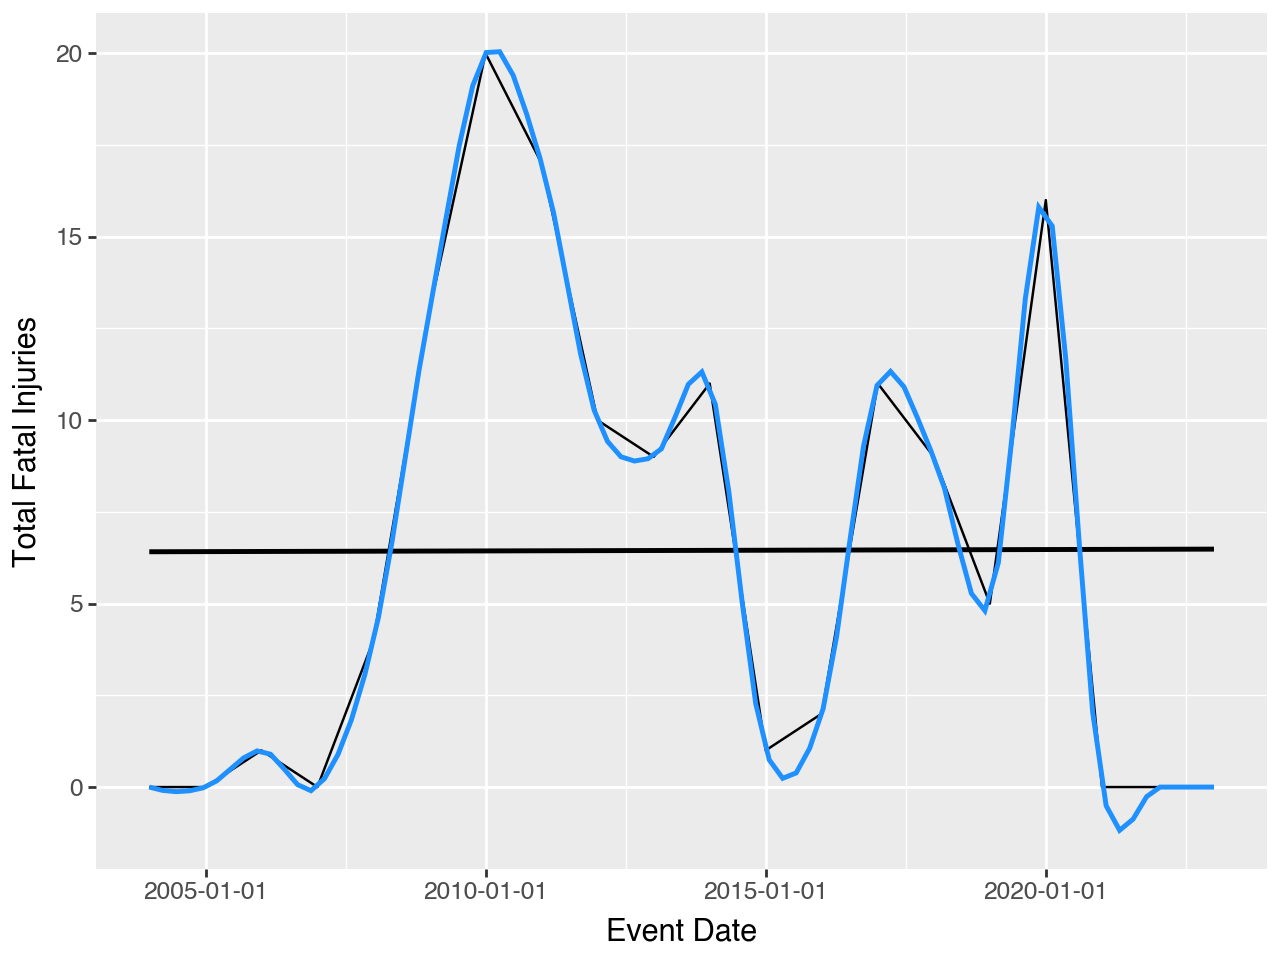

In [145]:
ggplot(
    mapping = aes('Event Date','Total Fatal Injuries'),
    data = temp_df_time_series
)\
+ geom_line()\
+ geom_smooth(method = 'lm', se=False)\
+ geom_smooth(method = 'loess', se=False, span = 0.2, color = 'dodgerblue')

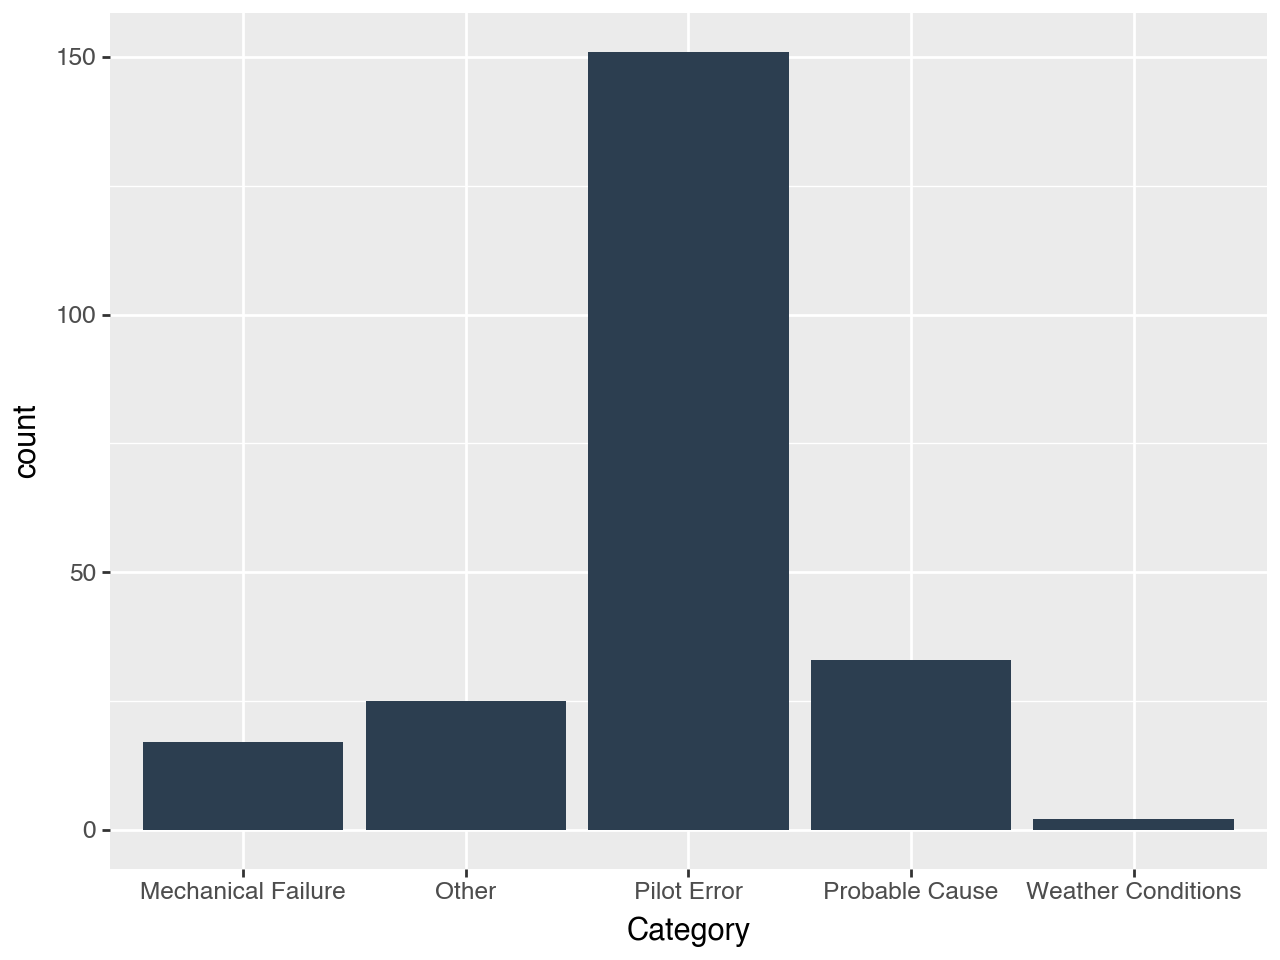

In [153]:
temp_df_category = temp_df[['Category']]
ggplot(
    mapping=aes(x='Category'),
    data=temp_df_category
) + geom_bar(fill='#2C3E50')

#### Accident Frequency by Make / Model

#### Correlation Between Engine Type and Accidents

#### Injury Severity and Weather Condition

#### Effect of Amateur Built Aircraft

#### Phase of Flight Accident Analysis

#### Geographical Risk Assessment

#### Engine Count and Safety

#### Aircraft Category and Injury Severity

#### Purpose of Flight and Accident Rates

#### Weather Conditions Impact on Accident Types

#### Total Injuries by Make and Mode

#### Probable Cause of Accidents by Model

#### Engine Type and Injury Severity

#### Accidents During Different Phases of Flight by Model

#### Time of Year and Accident Frequency

#### Incident vs. Accident Comparison

#### Impact of Weather on Different Makes/Models

#### Survivability Rate by Aircraft Model:

#### Comparison Between Countries

### Outcome Data

The outcome dataset also includes records from October 2013 to August 2020, and includes a variety of outcome types.

## Conclusions

This analysis leads to three recommendations for improving operations of the Austin Animal Center:

- **Engage in targeted outreach campaigns for dogs that have been sheltered at AAC for more than 30 days.** While most dogs will have been placed after 30 days, this may help reduce the number of dogs that end up having extended stays, potentially requiring many more months of care.
- **Reduce current spending until the numbers of intakes and sheltered animals return to normal.** Given the reduced activity during this period, AAC should consider ways to temporarily reduce costs by changing space utilization or staffing.
- **Hire seasonal staff and rent temporary space for May through December.** To accommodate the high volume of intakes and number of sheltered animals in the spring and fall, AAC should leverage seasonal resources, rather than full-year ones. This will allow AAC to cut back on expenditures during the months when there is lower

### Next Steps

Further analyses could yield additional insights to further improve operations at AAC:

- **Better prediction of animals that are likely to have long stays.** This modeling could use already available data, such as breed and intake condition.
- **Model need for medical support.** This modeling could predict the need for specialized personnel to address animals' medical needs, including neutering, using intake condition and sex data.
- **Predicting undesirable outcomes.** This modeling could identify animals that are more likely to have undesirable outcomes (e.g. Euthanasia) for targeted medical support or outreach.